### TODO::
- Torus, sphere, klein topologies
- 3D with projection

### References
https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html

In [83]:
%pylab inline
from sandpile import *
import pandas as pd
import numpy as np
import subprocess


def trim_grid(grid):
    # Trim empty
    grid = [r for r in grid if sum(r) > 0]
    # Trim empty columns
    w1 = len(grid[0])
    trans = [[r[n] for r in grid] for n in range(w1)]
    trans = [r for r in trans if sum(r) > 0]
    w2 = len(trans[0])
    grid = [[r[n] for r in trans] for n in range(w2)]

    return grid


def visualise(data, size=30, cmap="RdYlBu"):
    '''Greys YlGnBu are also good'''
    plt.figure(figsize=(size, size))
    sns.heatmap(data, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")


def from_csv(sandPower, pattern, seed="."):
    '''
    load stored data from the csv directory
    '''
    if seed == ".":
        path = "csv/2_{}_{}.csv".format(sandPower, pattern)
    else:
        path = "csv/2_{}_{}_{}.csv".format(sandPower, pattern, seed)
    data = np.genfromtxt(path, delimiter=",")
    return trim_grid(data)


def go_run(sandPower, pattern, seed="."):
    try:
        return from_csv(sandPower, pattern, seed)
    except:
        cmd = ["go", "run", "sandpile.go"]
        args = "{} {} {}".format(sandPower, pattern, seed)
        proc = subprocess.run(cmd, input=args.encode(), shell=True, stdout=subprocess.PIPE)
        print(proc)
        return from_csv(sandPower, pattern, seed)

Populating the interactive namespace from numpy and matplotlib


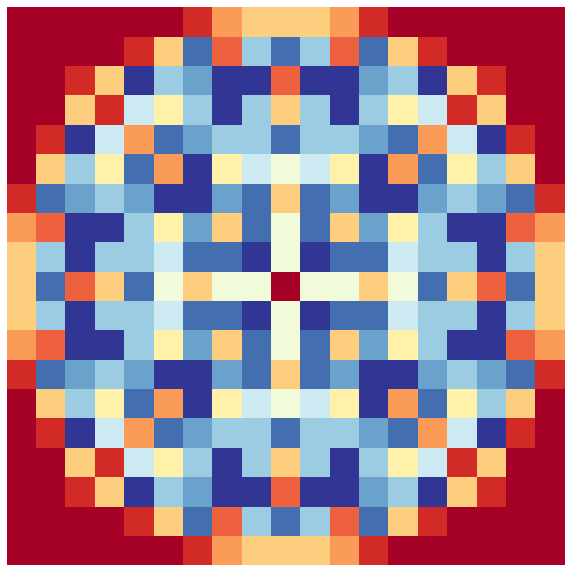

In [85]:
#data = from_csv(20, "++", ".")
data = go_run(11, "o+", ".")
visualise(data, 10)

Grid initialised:
side-length 10
initial sand 8

0 passes required
6.67572021484375e-05s to reach stable state


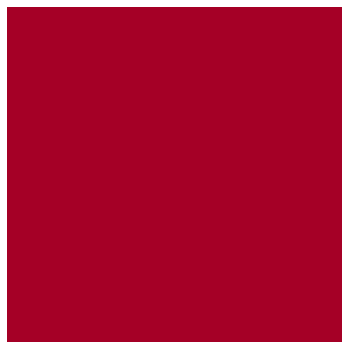

In [54]:
s = SandHeap(3, 'o+')
g = s.topple(True)
plt.figure(figsize=(6, 6))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

## o+ pattern: Number of passes required to reach stability vs starting sand


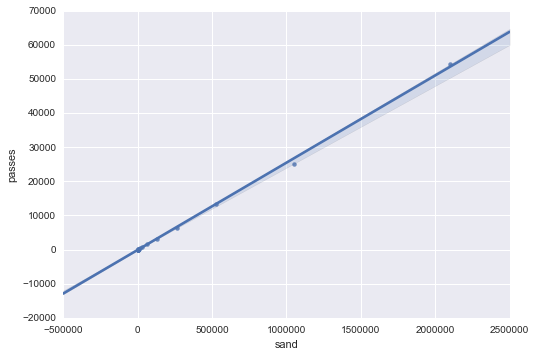

In [60]:
o_plusDF = pd.DataFrame(
    {
        "sand": [2 ** n for n in range(4,22)],
        "passes": [2, 2, 2, 4, 6, 12, 26, 40, 91, 173, 371, 755, 1541, 3162, 6402, 13421, 25166, 54344]
    }
)
sns.regplot("sand", "passes", df)

### Making a GIF
Run the generation first with the verbose flag enabled to see how many steps are required to reach stable state. In general, more that a few hundred frames for the gif results in a giant filesize so adjust the step and n values to get a sensible number of frames.

##### Cmap values
`
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, 
GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, 
Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, 
Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, 
Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, 
YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, 
cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, 
gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, 
gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, 
hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, 
plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, 
summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r
`

In [ ]:
animate(n=450, k=19, pat='o+', step=32, ftype='gif', fps=20, trim=False, cmap="RdYlBu")

In [ ]:
plt.figure(figsize=(18, 18))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")